# Occupancy gridmap building
# Starting Setup:
- A 2D laser simulator is provided.
- The environment is defined with lines. You can modify it.
- Localization is known.

# Implementation:
1. In order to build the map, the robot has to move within it. Implement the robot motion.
2. Implement the building of the occupancy gridmap with the information coming from the laser and the known robot pose. You would need to implement the inverse sensor model.

# Optional aspects:
1. Change the map definition to an arbitrary input image. Implement a new laser simulator able to work with this new representation (e.g. ray tracing).
2. Consider that the localization is not given, so you have to compute it when the robot moves. You can use, for example, ICP.
3. Implement different surfaces in the map, so the sensor performance may vary (e.g., appearing large errors). For example, black surfaces absorb more infrarred rays, difficulting sensor operation.
4. Laser related:
   - Test the effect of different real lasers (surf the internet to find them, e.g. Hokuyo, Sick) in the resulting map (different FOV, max range, resolution, error, etc.).
   - Implement additional sources of uncertainty in the laser measurements: random and max range.
   - Implement moving obstacles (people, pets, etc.).

# Given:
- A geometric map of the environment defined in an analytical form (lines of segments),
- Sensor properties:
   - FOV
   - Resolution
   - Maximum working distance
   - Characterization of the sensor noise
- Sensor pose,

Simulate a measurement of the said environment.

In [1]:
import numpy as np
from numpy import array, sin, cos, pi
import matplotlib.pyplot as plt
import math
import sys
from laser.laser2D import Laser2D
sys.path.append("..")
from utils.tcomp import tcomp
from utils.DrawRobot import DrawRobot

In [20]:
# DDA_LINE_ALGORITHM
def dda_line_algorithm(x1, y1, x2, y2):
    dx = x2 - x1
    dy = y2 - y1

    # Length of the line
    steps = abs(dx) if abs(dx) > abs(dy) else abs(dy)

    # Avoid division by zero
    if steps == 0:
        return [(x1, y1)]

    # Increment factors for x and y
    x_increment = dx / float(steps)
    y_increment = dy / float(steps)

    # Initialize starting coordinates
    x, y = x1, y1

    # Store the points
    line_points = []

    for _ in range(int(steps) + 1):
        line_points.append((int(x), int(y)))  # Adding the coordinates to the list
        x += x_increment  # Update x coordinate
        y += y_increment  # Update y coordinate

    return line_points

In [21]:
def calculate_new_position(laser_pose, z_i):
    x = int(np.round(laser_pose[0] + z_i[0] * np.cos(z_i[1] + laser_pose[2])))
    y = int(np.round(laser_pose[1] + z_i[0] * np.sin(z_i[1] + laser_pose[2])))
    return x, y

# This function updates the occupancy grid
def update_occupancy_map(occupancy_map, laser_pose, x, y, max_distance):
    x0 = int(np.round(laser_pose[0])) # starting position x0
    y0 = int(np.round(laser_pose[1])) # starting position y0
    
    # We use the DDA algorithm to draw the line and approximate the path between the starting position (x0, y0) and the end position (x, y
    path = dda_line_algorithm(x0, y0, x, y) # path is a list of tuples (x, y)
    for (n, m) in path: # for each cell in the line between the starting and end position
        if occupancy_map[m, n] != -1: # if the cell is not an obstacle
            occupancy_map[m, n] = 1  # set the cell to free
            
    if np.round(np.sqrt((x - x0) ** 2 + (y - y0) ** 2)) != max_distance: # if the last cell is not the max distance
        occupancy_map[y, x] = -1 # set the cell to occupied

In [55]:
# Define the environment
map = np.array([[0, 0, 4, 4, 6, 8, 10, 10, 8, 4, 4, 1, 0], 
                [4, 0, 0, 2, 2, 0, 0, 4, 6, 6, 5, 5, 4]])*1.5
# fig, ax = plt.subplots()
# plt.xlim([-2,17]), plt.ylim([-2,11]),
# plt.plot(map[0,:],map[1,:])


# Initialize the occupancy grid
grid_resolution = 0.5
occupancy_map = np.zeros((15, 20), dtype=np.int32)

# Set robot pose and drow it
robot_pose = np.vstack([3., 3., np.pi/4]) # [x,y,theta]
# DrawRobot(fig, ax, robot_pose, color='red')

# Set the increment pose
inc_pose = np.vstack([2.0, 0.0, -np.pi/10])  # [x, y, theta]

epoc = 7

# Prepare the laser
FOV = 180 * np.pi/180        # radians
resolution = 10 * np.pi/180  #radians
max_distance = 10         # meters
noise_cov = np.array([[0.005, 0],[0, 0.0002]]) # covariance matrix
laser_pose = robot_pose   # [x,y,theta]

# # Take and draw an observation!
# laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
# z = laser.take_observation(map)
# laser.draw_observation(z,laser_pose,fig,ax)
# plt.show()

C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = int(np.round(laser_pose[0] + z_i[0] * np.cos(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(np.round(laser_pose[1] + z_i[0] * np.sin(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

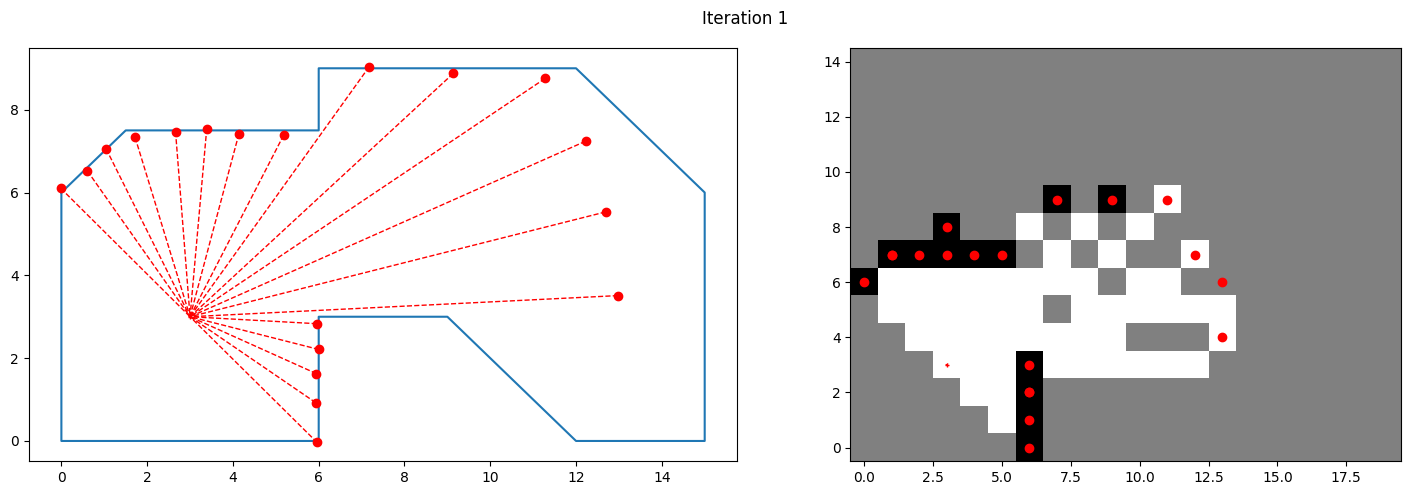

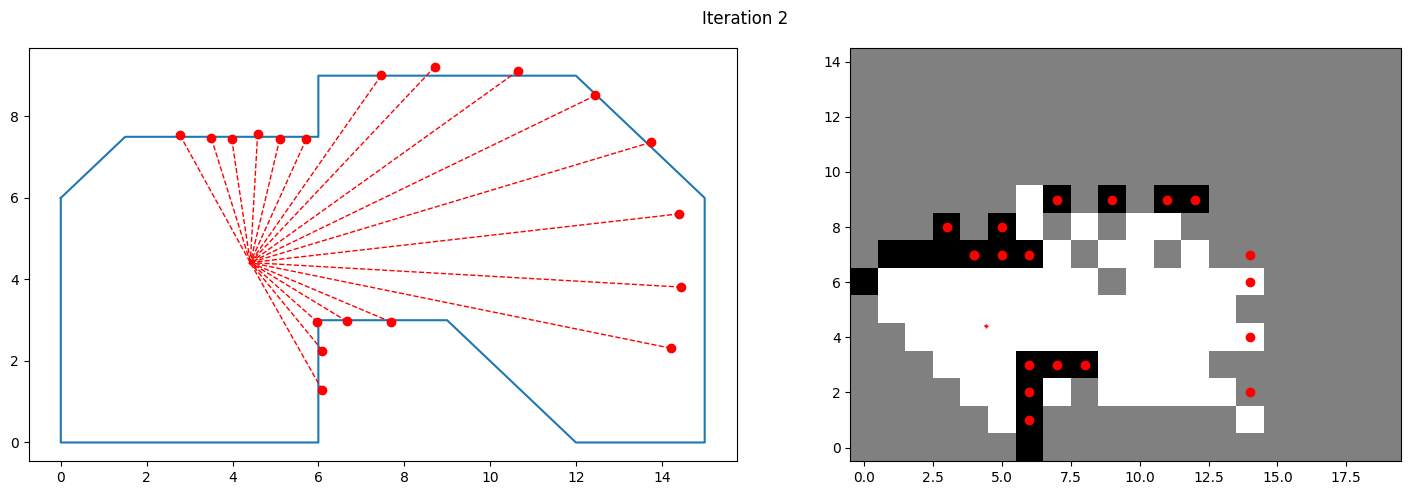

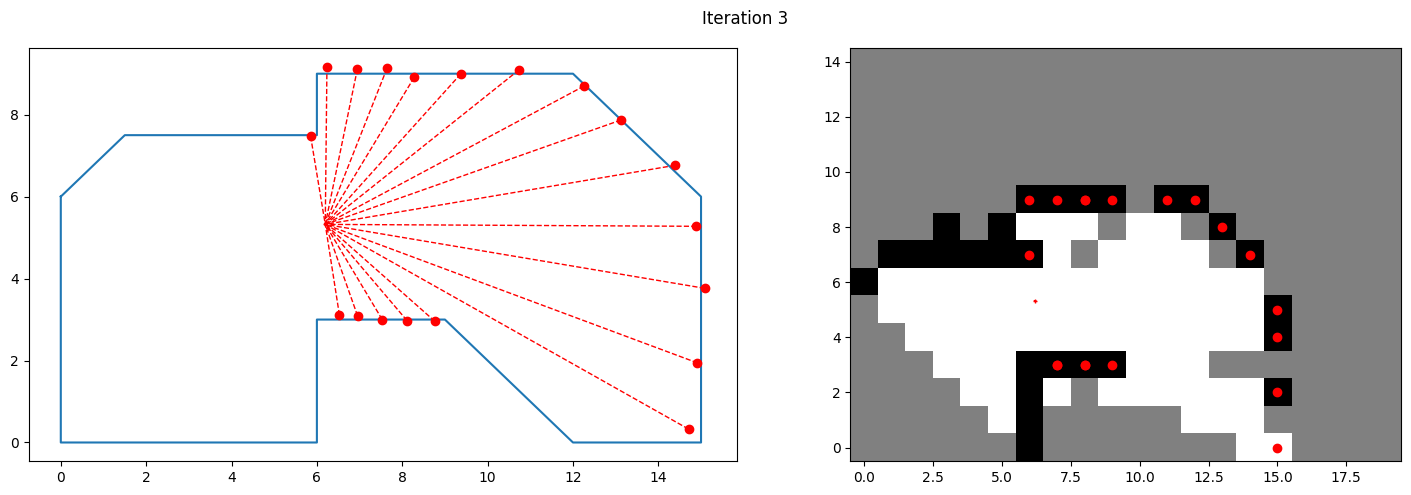

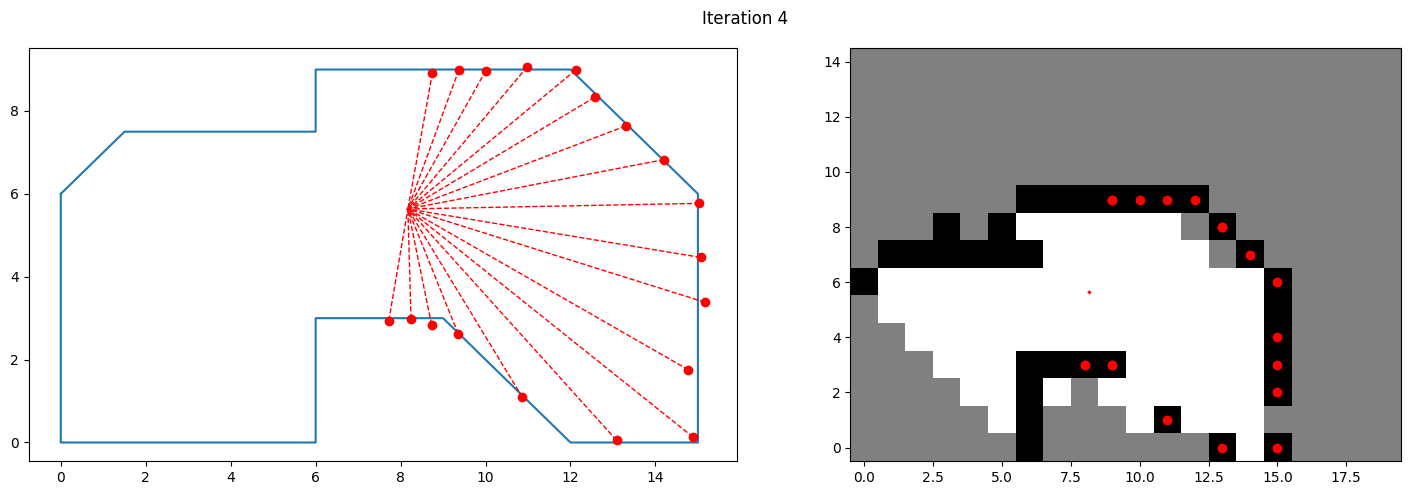

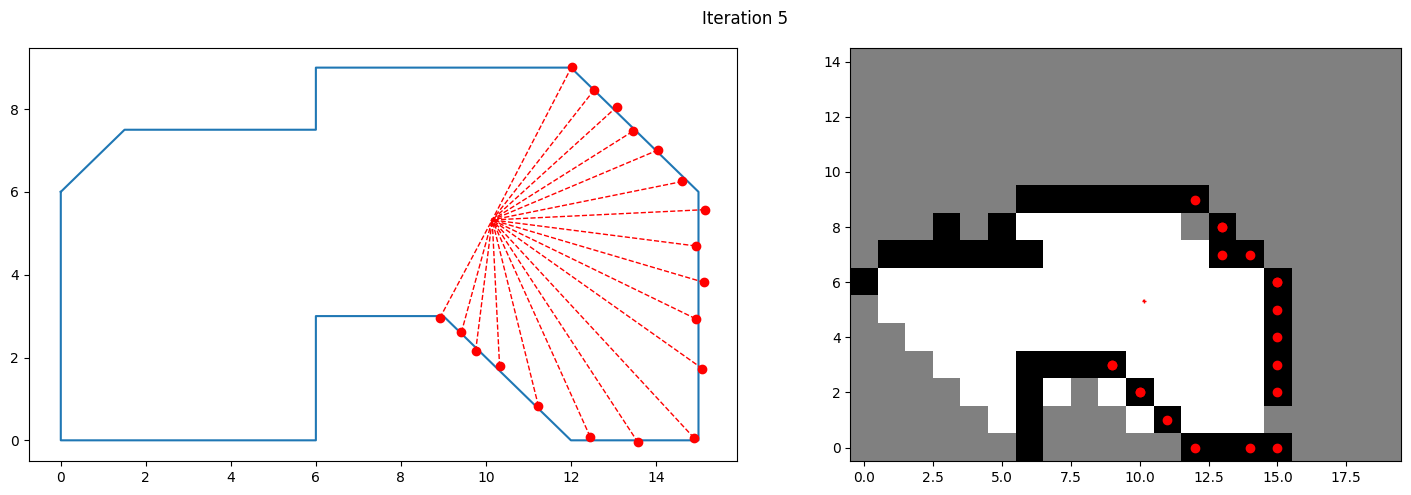

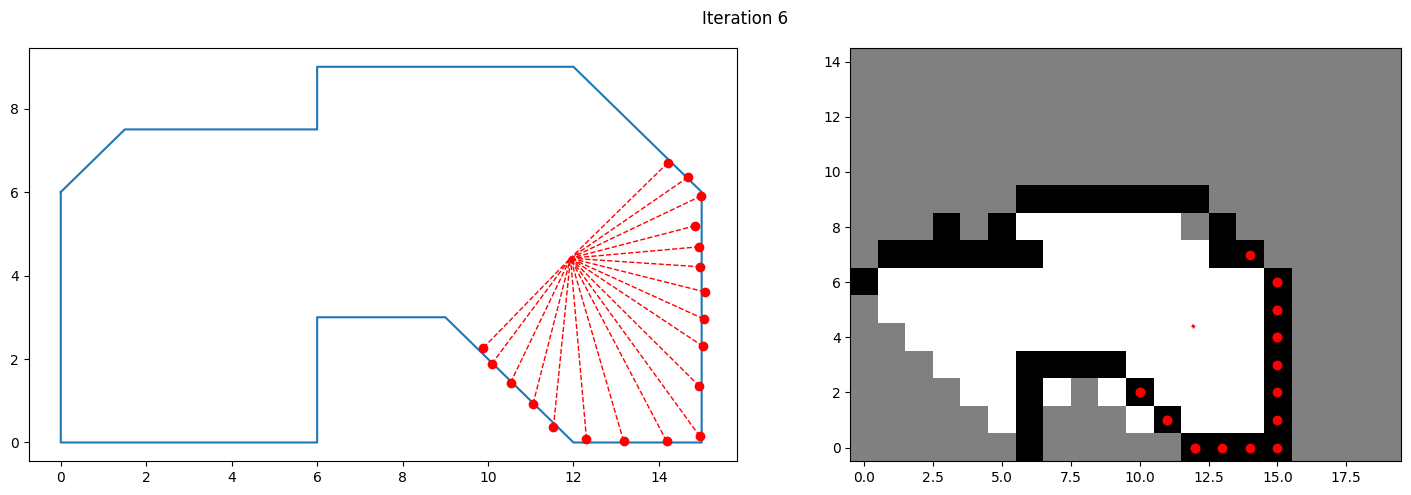

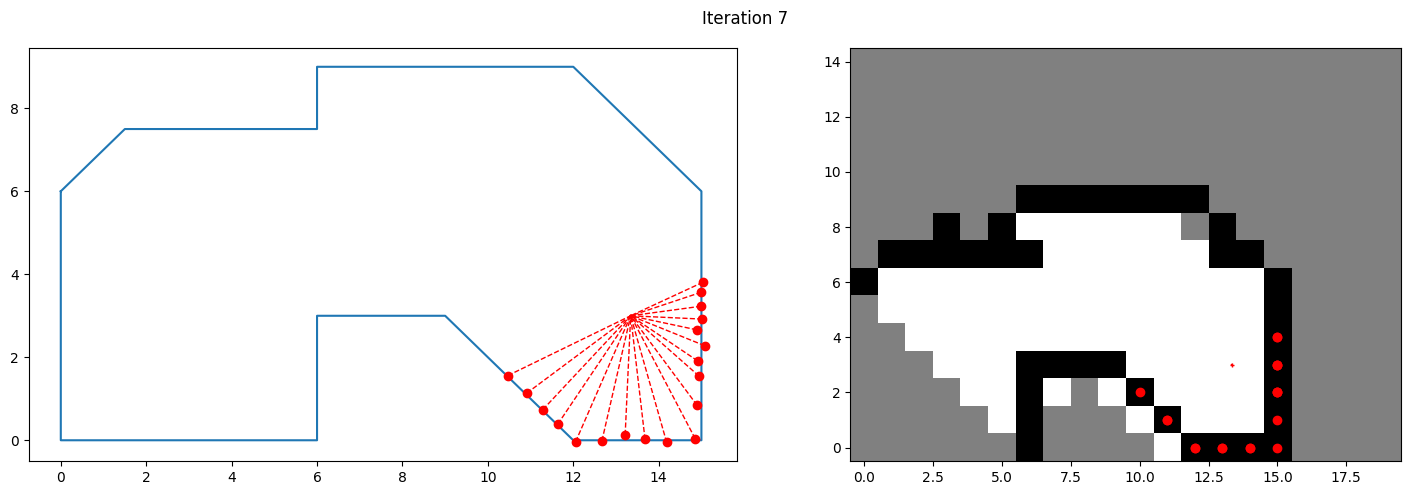

In [56]:
for iter in range(1, epoc + 1):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Set the overall title for the iteration
    fig.suptitle(f"Iteration {iter}")
    
    # Visualize the map on the left subplot (ax1)
    ax1.plot(map[0, :], map[1, :])  # Plotting the environment map
    DrawRobot(fig, ax1, robot_pose, color='red')  # Displaying the robot's current position
    
    # Visualize the occupancy grid on the right subplot (ax2)
    DrawRobot(fig, ax2, robot_pose, color='red')  # Displaying the robot's current position
    
    # Acquire and display laser observations on ax1
    laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
    z = laser.take_observation(map)
    laser.draw_observation(z, laser_pose, fig, ax1)  # Plotting laser scan observations
    
    # Process laser observations and update the occupancy map on ax2
    for i in range(z.shape[1]):
        z_i = z[:, i]  # Extracting individual laser observation
        x, y = calculate_new_position(laser_pose, z_i)  # Calculating the position based on the observation
        ax2.plot(x, y, 'ro')  # Marking the detected objects on the occupancy grid
        
        # Update the occupancy grid map based on the observations
        update_occupancy_map(occupancy_map, laser_pose, x, y, max_distance)
    
    # Display the occupancy map as an image on ax2
    ax2.imshow(occupancy_map, cmap='gray', origin='lower')
    
    # Update the robot and laser poses for the next iteration
    robot_pose = tcomp(robot_pose, inc_pose)
    laser_pose = robot_pose
    
    # Adjust the layout for better visualization and display the figure
    plt.tight_layout()
    plt.show()


## Hoyuko Laser

The Hokuyo Laser provides accurate distance measurements and is renowned for its reliability and precision. Utilizing laser technology, it emits infrared beams and measures the time it takes for these beams to reflect off objects and return to the sensor, thereby determining distances with high accuracy. Due to its compact size, robustness, and effectiveness in various environmental conditions, the Hokuyo Laser is widely adopted in navigation, mapping, obstacle detection, and other robotics tasks, enabling precise and efficient operations in diverse applications.

Video overview: https://youtu.be/7N_aOU7MG7o?si=EC4wiuxDhkOzuAlM

<!-- Center and reduce the size of Hoyuko Laser image -->
<p align="center">
  <img src="img/HoyukoLaser.jpg" alt="Hoyuko Laser" width="300" height="300">
</p>

In [80]:
# Define the environment for Hokuyo Laser
map = np.array([[0, 0, 4, 4, 6, 8, 10, 10, 8, 4, 4, 1, 0], 
                [4, 0, 0, 2, 2, 0, 0, 4, 6, 6, 5, 5, 4]]) * 1.5

# Create a grid representing the occupancy map
grid_resolution = 0.5
occupancy_map = np.zeros((15, 20), dtype=np.int32)

# Set robot pose for Hokuyo Laser
robot_pose = np.vstack([1., 1., np.pi/4])  # [x, y, theta]
inc_pose = np.vstack([2.0, 0.0, -np.pi/20])  # [x, y, theta]
epoc = 7

# Prepare the Hokuyo Laser
FOV = 180 * np.pi/180  # radians
resolution = 0.25 * np.pi/180  # radians (specific to Hokuyo)
max_distance = 30  # meters (specific to Hokuyo)
noise_cov = np.array([[0.005, 0], [0, 0.0002]])  # covariance matrix (specific to Hokuyo)
laser_pose = robot_pose  # same as the robot for Hokuyo


C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = int(np.round(laser_pose[0] + z_i[0] * np.cos(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(np.round(laser_pose[1] + z_i[0] * np.sin(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

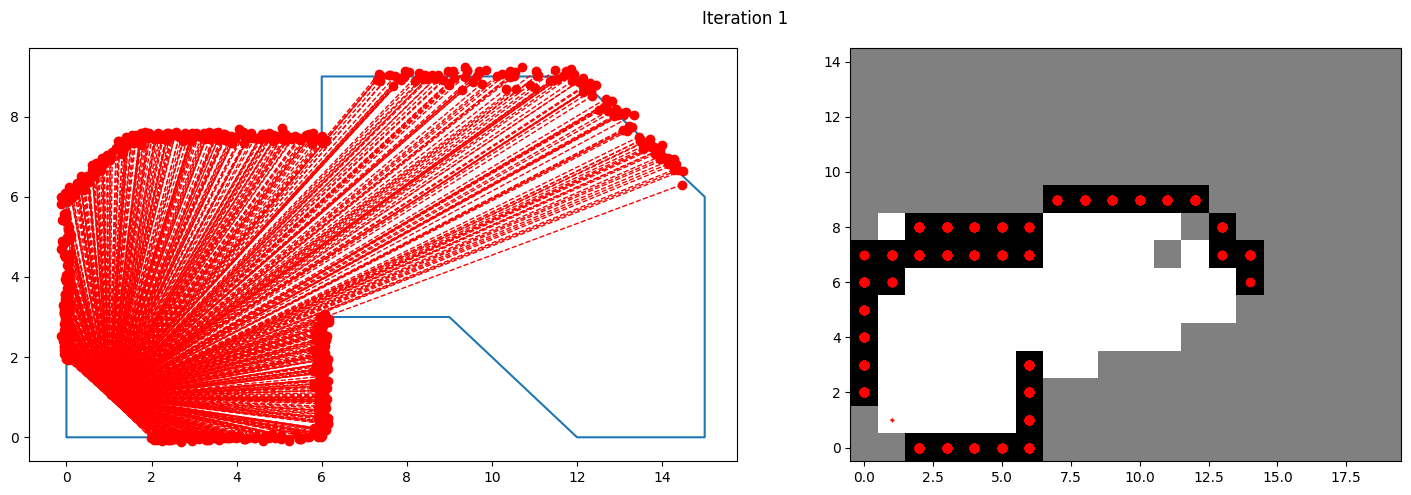

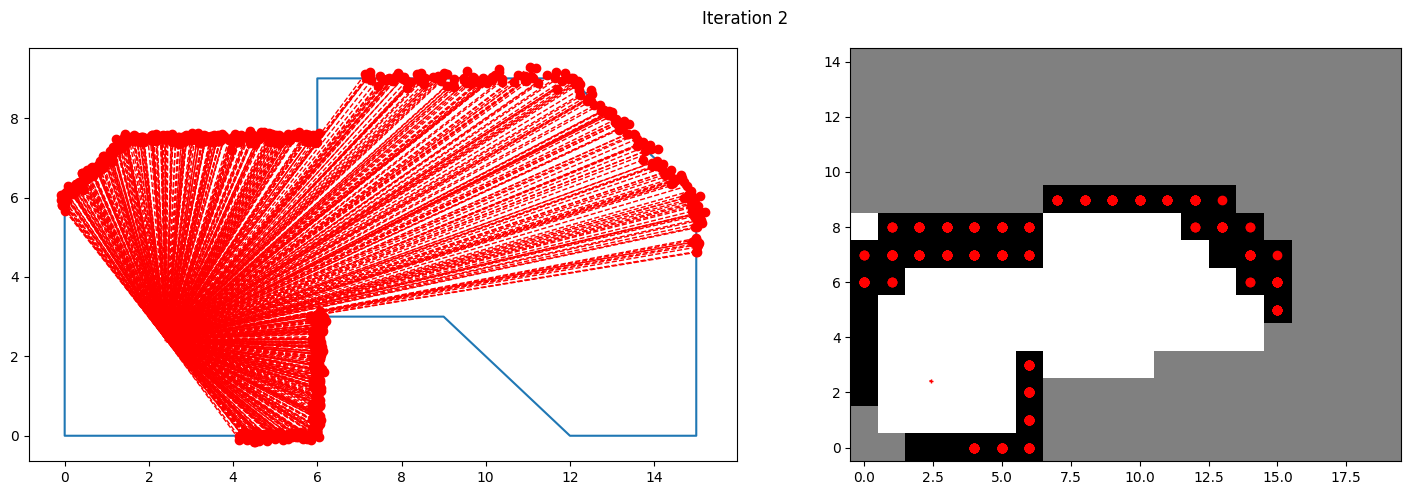

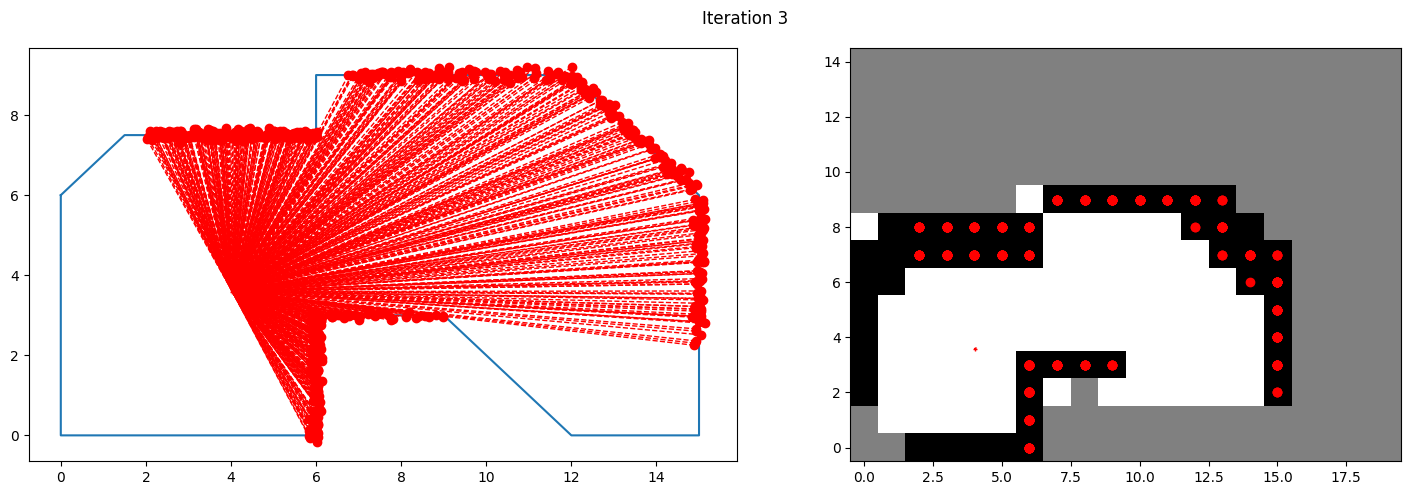

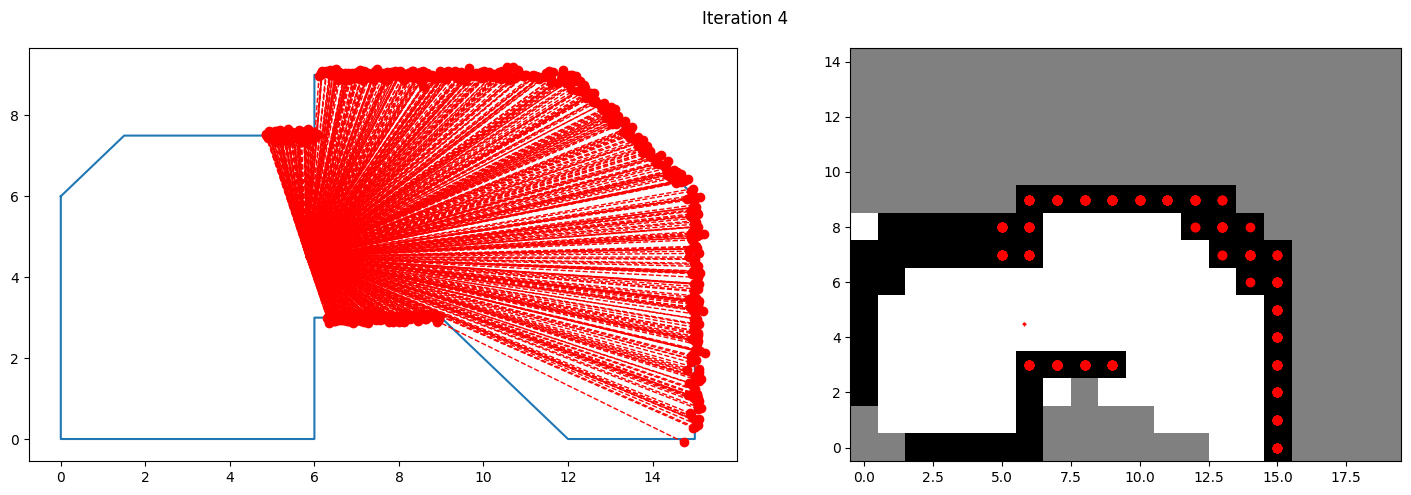

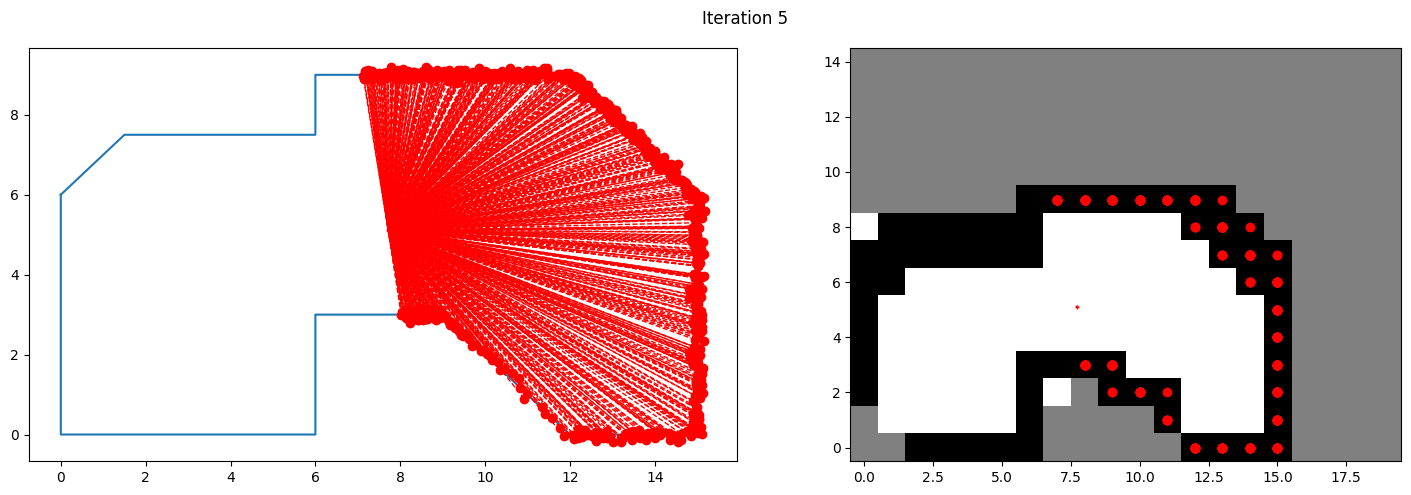

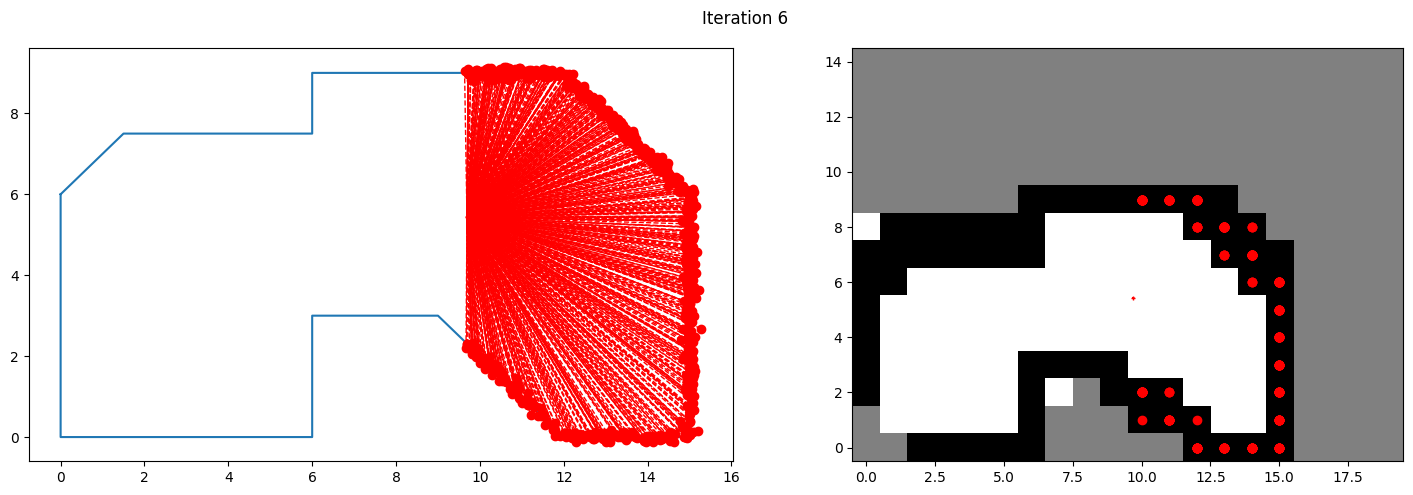

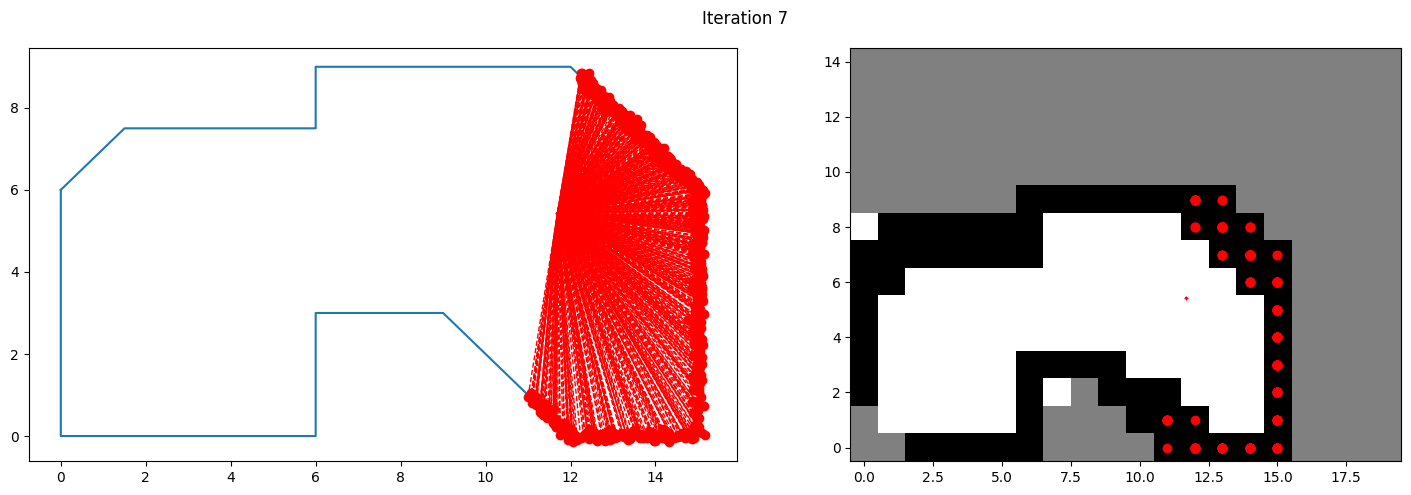

In [81]:
for iter in range(1, epoc + 1):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Set the overall title for the iteration
    fig.suptitle(f"Iteration {iter}")
    
    # Visualize the map on the left subplot (ax1)
    ax1.plot(map[0, :], map[1, :])  # Plotting the environment map
    DrawRobot(fig, ax1, robot_pose, color='red')  # Displaying the robot's current position
    
    # Visualize the occupancy grid on the right subplot (ax2)
    DrawRobot(fig, ax2, robot_pose, color='red')  # Displaying the robot's current position
    
    # Acquire and display laser observations on ax1
    laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
    z = laser.take_observation(map)
    laser.draw_observation(z, laser_pose, fig, ax1)  # Plotting laser scan observations
    
    # Process laser observations and update the occupancy map on ax2
    for i in range(z.shape[1]):
        z_i = z[:, i]  # Extracting individual laser observation
        x, y = calculate_new_position(laser_pose, z_i)  # Calculating the position based on the observation
        ax2.plot(x, y, 'ro')  # Marking the detected objects on the occupancy grid
        
        # Update the occupancy grid map based on the observations
        update_occupancy_map(occupancy_map, laser_pose, x, y, max_distance)
    
    # Display the occupancy map as an image on ax2
    ax2.imshow(occupancy_map, cmap='gray', origin='lower')
    
    # Update the robot and laser poses for the next iteration
    robot_pose = tcomp(robot_pose, inc_pose)
    laser_pose = robot_pose
    
    # Adjust the layout for better visualization and display the figure
    plt.tight_layout()
    plt.show()


## Sick Laser

The SICK laser scanner, often referred to as a LiDAR (Light Detection and Ranging) sensor, is another prominent device in the realm of robotics and industrial automation. SICK laser scanners utilize laser technology to emit light pulses, which bounce off objects in their path and return to the sensor. By measuring the time it takes for these pulses to return, the scanner calculates the distances to surrounding objects, generating a detailed 2D or 3D representation of the environment. Known for its accuracy, speed, and reliability, the SICK laser scanner is instrumental in applications such as autonomous navigation, object detection, localization, and mapping. Its versatility and robust performance make it a preferred choice for industries ranging from manufacturing and logistics to agriculture and automotive, facilitating safer and more efficient operations in complex environments.

Video overview: https://youtu.be/sR9q96pPYqA?si=5ctB0zKP_6QyqRnL

<!-- Center and reduce the size of Sick Laser image -->
<p align="center">
  <img src="img/SickLaser.jpeg" alt="Sick Laser" width="300" height="200">
</p>

In [86]:
# Define the environment for Sick Laser
map = np.array([[0, 0, 4, 4, 6, 8, 10, 10, 8, 4, 4, 1, 0], 
                [4, 0, 0, 2, 2, 0, 0, 4, 6, 6, 5, 5, 4]]) * 1.5

# Create a grid representing the occupancy map
grid_resolution = 0.5
occupancy_map = np.zeros((15, 20), dtype=np.int32)

# Set robot pose for Sick Laser
robot_pose = np.vstack([1., 1., np.pi/4])  # [x, y, theta]
inc_pose = np.vstack([2.0, 0.0, -np.pi/20])  # [x, y, theta]
epoc = 7

# Prepare the Sick Laser
FOV = 270 * np.pi/180  # radians (specific to Sick)
resolution = 0.5 * np.pi/180  # radians (specific to Sick)
max_distance = 50  # meters (specific to Sick)
noise_cov = np.array([[0.004, 0], [0, 0.0003]])  # covariance matrix (specific to Sick)
laser_pose = robot_pose  # same as the robot for Sick

C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x = int(np.round(laser_pose[0] + z_i[0] * np.cos(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y = int(np.round(laser_pose[1] + z_i[0] * np.sin(z_i[1] + laser_pose[2])))
C:\Users\isidr\AppData\Local\Temp\ipykernel_10868\943013811.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecate

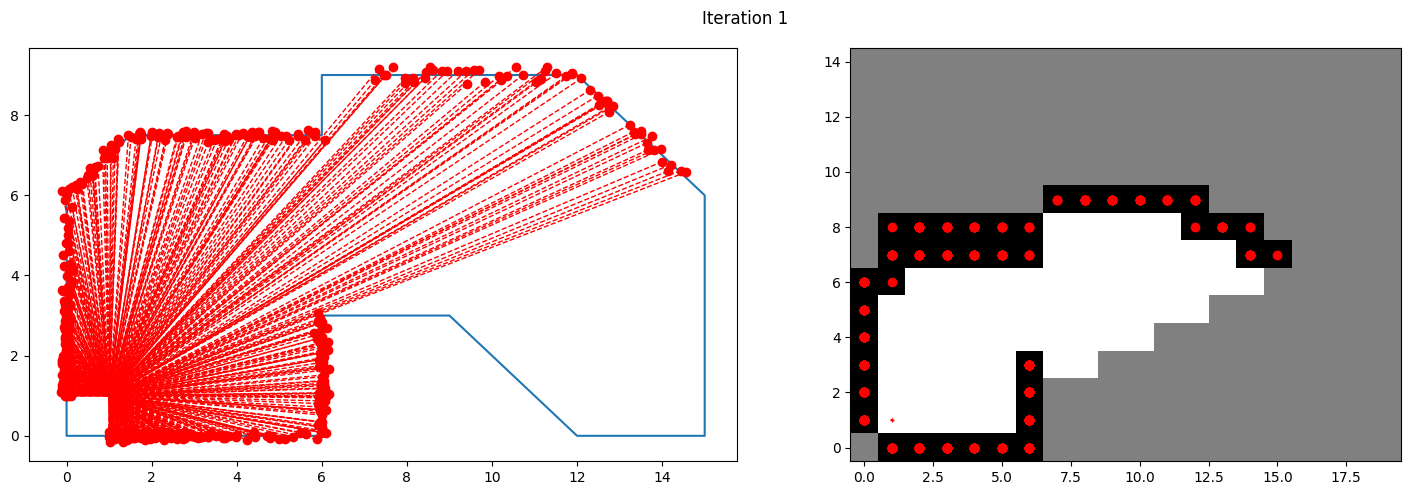

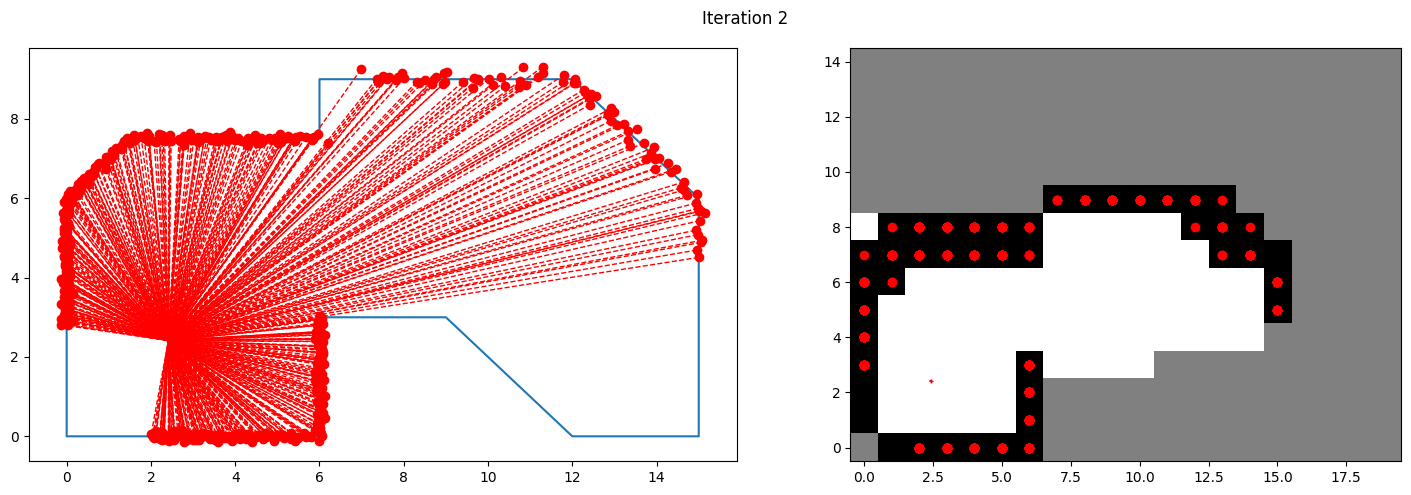

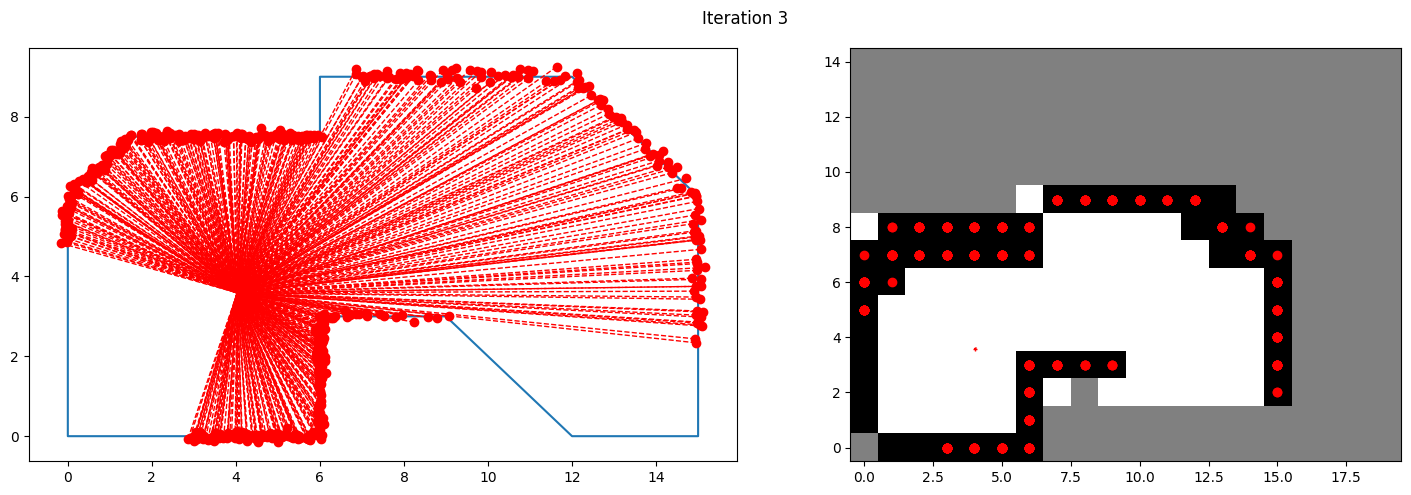

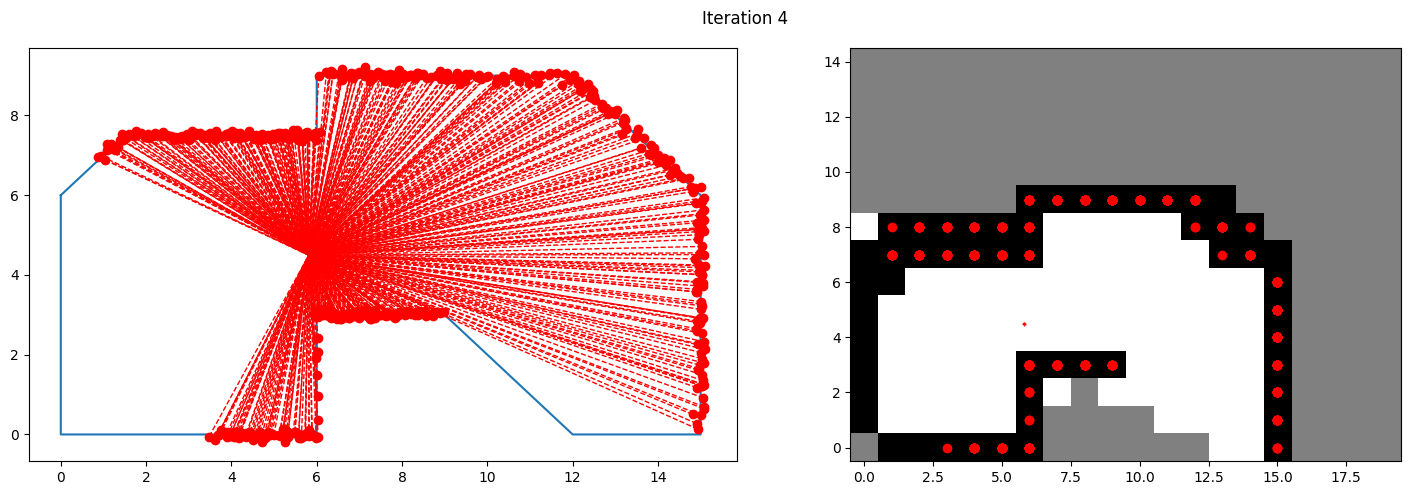

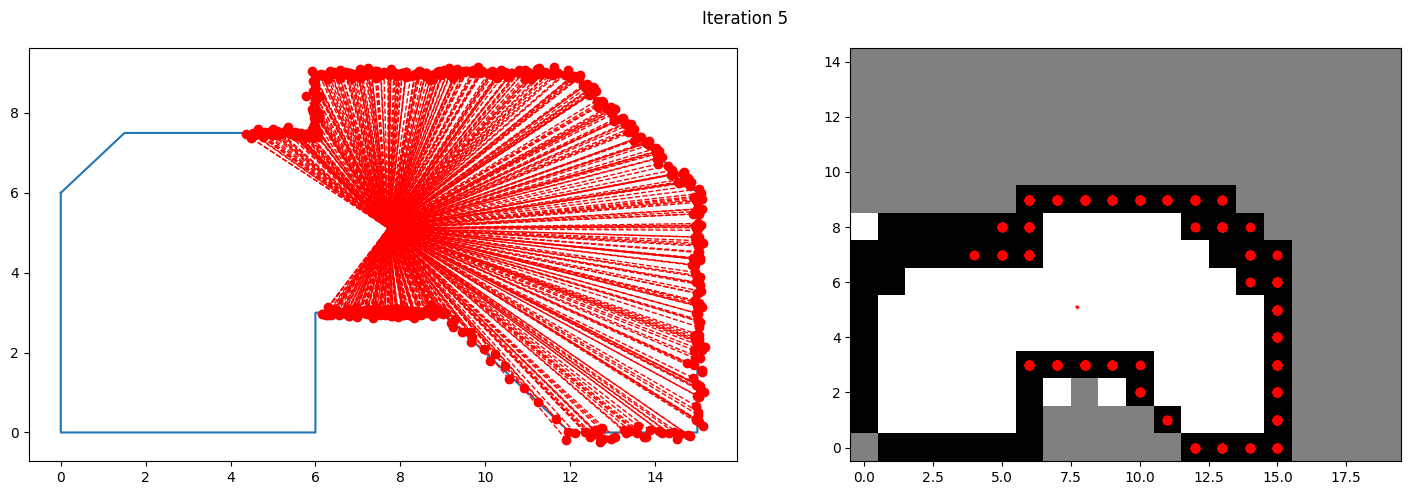

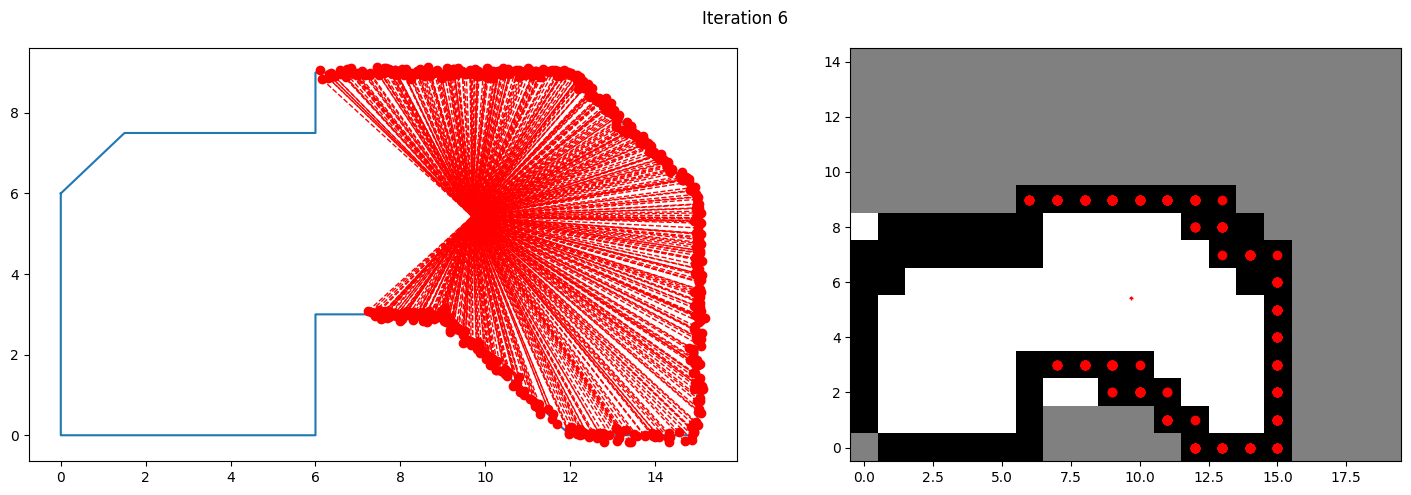

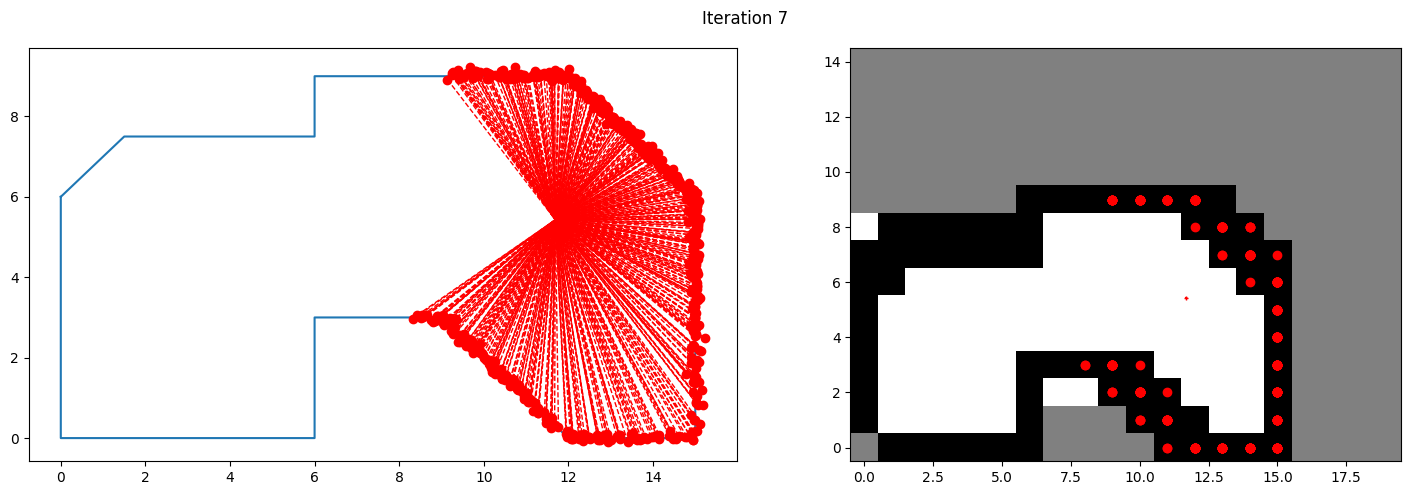

In [87]:
for iter in range(1, epoc + 1):
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Set the overall title for the iteration
    fig.suptitle(f"Iteration {iter}")
    
    # Visualize the map on the left subplot (ax1)
    ax1.plot(map[0, :], map[1, :])  # Plotting the environment map
    DrawRobot(fig, ax1, robot_pose, color='red')  # Displaying the robot's current position
    
    # Visualize the occupancy grid on the right subplot (ax2)
    DrawRobot(fig, ax2, robot_pose, color='red')  # Displaying the robot's current position
    
    # Acquire and display laser observations on ax1
    laser = Laser2D(FOV, resolution, max_distance, noise_cov, laser_pose)
    z = laser.take_observation(map)
    laser.draw_observation(z, laser_pose, fig, ax1)  # Plotting laser scan observations
    
    # Process laser observations and update the occupancy map on ax2
    for i in range(z.shape[1]):
        z_i = z[:, i]  # Extracting individual laser observation
        x, y = calculate_new_position(laser_pose, z_i)  # Calculating the position based on the observation
        ax2.plot(x, y, 'ro')  # Marking the detected objects on the occupancy grid
        
        # Update the occupancy grid map based on the observations
        update_occupancy_map(occupancy_map, laser_pose, x, y, max_distance)
    
    # Display the occupancy map as an image on ax2
    ax2.imshow(occupancy_map, cmap='gray', origin='lower')
    
    # Update the robot and laser poses for the next iteration
    robot_pose = tcomp(robot_pose, inc_pose)
    laser_pose = robot_pose
    
    # Adjust the layout for better visualization and display the figure
    plt.tight_layout()
    plt.show()
